# Applying TreeExplainers for tree ensemble models
## CHAPTER 07 - *Practical exposure of using SHAP in ML*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

We will explore the usage of TreeExplainers in SHAP used for explaining tree ensemble models. Please check out *Chapter 7 - Practical exposure of using SHAP in ML* for other interesting approaches of using SHAP in practice.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade numpy pandas matplotlib seaborn sklearn lightgbm shap

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(123)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import shap
print(f"Shap version used: {shap.__version__}")
# Initialize JS visualization for the notebook
shap.initjs()

Shap version used: 0.40.0


### About the dataset

**German Credit Risk** | [Kaggle](https://www.kaggle.com/uciml/german-credit)

The dataset that we will be using for this tutorial for used for classifying Good Risk and Bad Risk. The dataset is a derived dataset taken from Kaggle. The original source of the dataset is [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) which contains 1000 entries with 20 categorial or symbolic features prepared by Professor Dr. Hans Hofmann, Institut f"ur Statistik und "Okonometrie Universit"at Hamburg, such that each entry represents a person who takes a credit by a bank. Each applicant is categorized as good or bad credit risks according to the set of features present in the dataset. But the current dataset is a simplified one with less number of features and the dataset has been added in the project repository to make it more accessible. The following are the key attributes present in dataset according to the Kaggle source:
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

### Loading the data

In [2]:
data  = pd.read_csv('datasets/german_credit_data.csv', index_col=0)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
data.shape

(1000, 10)

In [4]:
data.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [6]:
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Purpose']

In [7]:
data[num_features].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


From the dataset info, we can see that the features *Saving accounts* and *Checking account* does have some missing values. The percentage of missing values also seems to be higher for ignoring the entire row of records and hence we might need to apply data imputation.

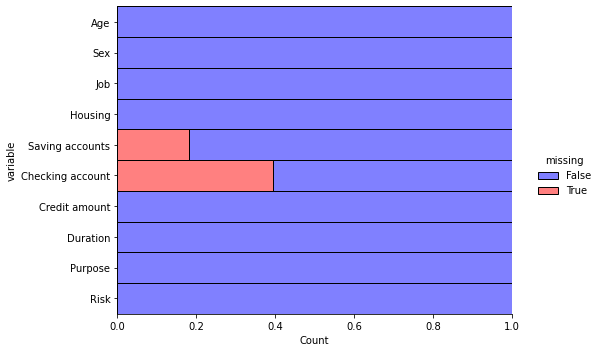

In [8]:
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5,
    palette='seismic'
)
plt.show()

In [9]:
missing_features = ['Saving accounts', 'Checking account']
data[missing_features].isna().sum()/1000 * 100

Saving accounts     18.3
Checking account    39.4
dtype: float64

In [10]:
print(data[missing_features[0]].value_counts())
print(data[missing_features[1]].value_counts())

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


For the features having moderately high amount of missing values, we cannot completely ignore the records or drop the feature. So, we need to definitely apply data imputation. For simplifying the data imputation technique, we will impute these categorical features with another "Unknown" category, but ideally there needs to some experimentation and the thought process should be more robust to select other types of imputation. But like the previous tutorials, our goal is to focus on the model explainability part and not towards building robust ML models. Even if the model is not good enough, we can focus on using SHAP to explain the same. But to proceed with the explainability process, we will apply median imputation and build a baseline ML model using a tree ensemble algorithm.

In [11]:
data.fillna('Unknown', inplace=True)

In [12]:
print(data[missing_features].isna().sum()/1000 * 100)
print(data[missing_features[0]].value_counts())
print(data[missing_features[1]].value_counts())

Saving accounts     0.0
Checking account    0.0
dtype: float64
little        603
Unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
Unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


In [13]:
# Check for duplicate values
data.duplicated().any()

False

We will use **Light Gradient Boosting Machine (LGBM) algorithm** (https://lightgbm.readthedocs.io/en/latest/) for the ML modelling part, which can directly use categorical variables, and hence we will not go for One-Hot Encoding. Otherwise, it is essential to apply OneHot Encoding before proceeding.

In [14]:
# Label Encoding output variable
le = LabelEncoder()
for feat in ['Sex', 'Housing', 'Saving accounts','Checking account', 'Purpose','Risk']:
    le.fit(data[feat])
    data[feat] = le.transform(data[feat])
classes = list(le.classes_)
print(classes)
data.head()

['bad', 'good']


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,1
1,22,0,2,1,1,2,5951,48,5,0
2,49,1,1,1,1,0,2096,12,3,1
3,45,1,2,0,1,1,7882,42,4,1
4,53,1,2,0,1,1,4870,24,1,0


For this tutorial, we will stop at here for the data pre-processing or feature engineering part. We will not perform any other complex feature engineering, data normalization or any other transformation as the primary objective is to focus on model explainability using SHAP TreeExplainers. So, let's proceed building a baseline tree ensemble ML model using the **Light Gradient Boosting Machine (LGBM) algorithm** (https://lightgbm.readthedocs.io/en/latest/). Let us proceed!

### Training the model

In [15]:
features = data.drop(columns=['Risk'])
labels = data['Risk']
# Dividing the data into training-test set with 80:20 split ratio
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

In [16]:
x_train.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [17]:
# Create LightGBM Dataset
data_train = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_features)
data_test = lgb.Dataset(x_test, label=y_test, categorical_feature=cat_features)

In [18]:
# Define the model configurations as a dictionary
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 123
}

In [19]:
model = lgb.train(params,
                  data_train,
                  num_boost_round=100,
                  verbose_eval=100,
                  valid_sets=[data_test, data_train])

[100]	training's auc: 0.91555	valid_0's auc: 0.805166


In [20]:
y_pred = model.predict(x_test)

In [21]:
y_pred = [1 if y > 0.5 else 0 for y in y_pred]

In [22]:
print(f'Accuracy for the baseline model is: {accuracy_score(y_test, y_pred)}')

Accuracy for the baseline model is: 0.775


Thus, we can see a model which is decent, but it is definitely over-fitting. Now, we would like to focus on the model explainability using SHAP TreeExplainers.

### Model Explainability using SHAP TreeExplainers

In [23]:
%%time
# Building a SHAP Explainer model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

Wall time: 144 ms


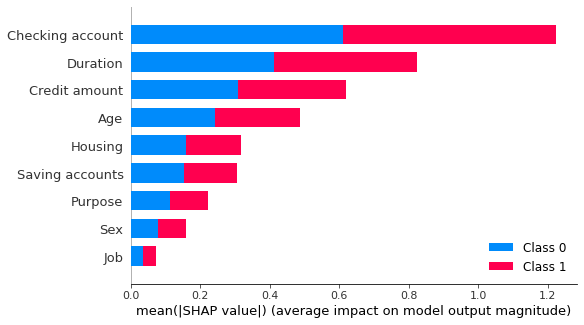

In [24]:
# Global explainability with summary plots
shap.summary_plot(shap_values, features)

As we can see that with few lines of code we can use TreeSHAP based TreeExplainers for model explainability. Summary plots in SHAP produce global explainability by showing us Shapley value based important features. So, from the above plot we can visualize the important features and from the dataset, Checking account, Duration and Credit amount has the most importance.

In [25]:
# Local explainability with force plots
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])

We can apply the force plots from SHAP for the local interpretability. As we can see the force plot visual, for the given data instance, checking amount, credit amount and job status plays a negative influence. Otherwise Duration and Age has the maximum positive influence on the data for the model prediction.

Force plots can be difficult to understand, if there are more number of features. In such cases, decision plots are quite useful. This is how we can use decision plots with TreeExplainers.

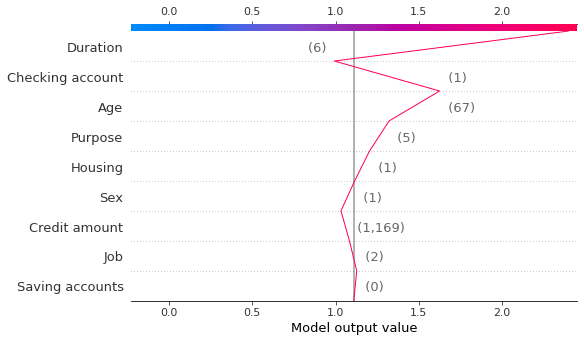

In [26]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])

Understanding feature dependence is also crucial, especially for global interpretability. This is how we can use dependence plots in SHAP for understanding the global feature impact.

Feature Dependence plot for: Sex


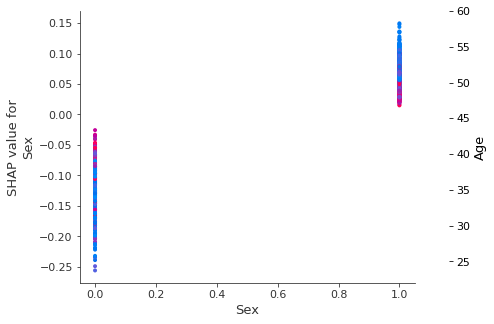

Feature Dependence plot for: Housing


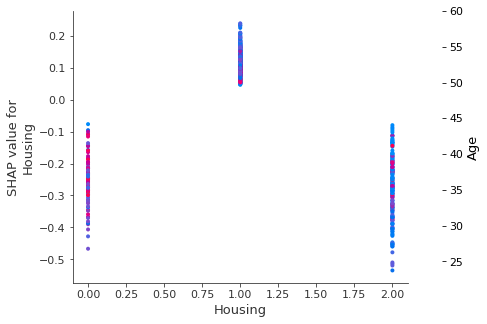

Feature Dependence plot for: Saving accounts


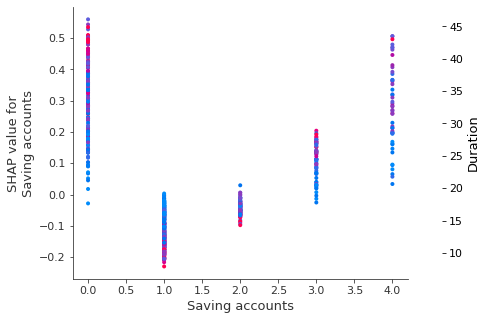

Feature Dependence plot for: Checking account


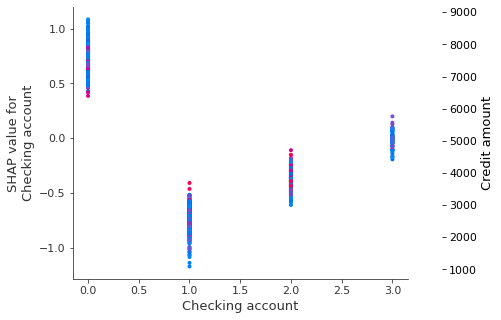

Feature Dependence plot for: Purpose


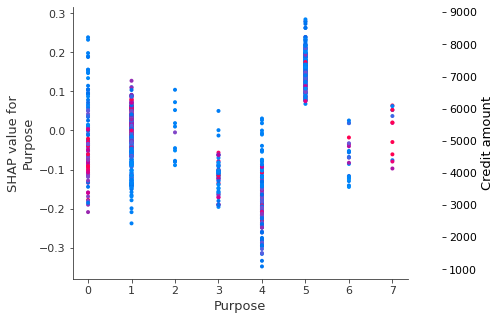

Feature Dependence plot for: Credit amount


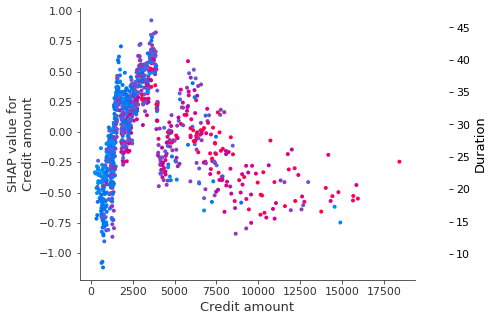

Feature Dependence plot for: Age


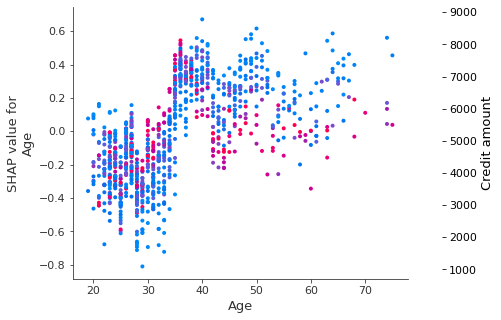

In [27]:
# For feature wise global interpretability
for col in ['Sex', 'Housing', 'Saving accounts','Checking account', 'Purpose', 'Credit amount', 'Age']:
    print(f"Feature Dependence plot for: {col}")
    shap.dependence_plot(col, shap_values[1], features, display_features=features)

## Final Thoughts

TreeExplainer in SHAP is really fast and it can be applied to tree ensemble models very easily! But, I personally feel human interpretability in SHAP is still low, especially when it is used for local interpretability. LIME was more simple to understand. But in general, SHAP is conceptually more rigid, but it does require additional engineering effort to make the explanation explicitly easy to understand for non-technical experts.

## Reference

1. German Credit Risk Dataset - https://www.kaggle.com/uciml/german-credit
2. SHAP GitHub Project - https://github.com/slundberg/shap
3. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073